## Chapter 6

1. 

a. Best subset selection has the smallest training RSS because the other two methods determine models with a path dependency on which predictors they pick first as they iterate to the k'th model.

b. Best subset selection may have the smallest test RSS because it considers more models then the other methods. However, the other models might have better luck picking a model that fits the test data better.

c. i. True. ii. True. iii. False. iv. False. v. False.


2. 

a. (LASSO) iii. Less flexible and better predictions because of less variance, more bias

b. (Ridge) Same as lasso. iii.
 
c. (Non-linear methods) ii. More flexible, less bias, more variance


3. 

a. k-fold cross-validation is implemented by taking the set of n observations and randomly splitting into k non-overlapping groups. Each of these groups acts as a validation set and the remainder as a training set. The test error is estimated by averaging the k resulting MSE estimates.

b. i. The validation set approach is conceptually simple and easily implemented as you are simply partitioning the existing training data into two sets. However, there are two drawbacks: (1.) the estimate of the test error rate can be highly variable depending on which observations are included in the training and validation sets. (2.) the validation set error rate may tend to overestimate the test error rate for the model fit on the entire data set.

ii. LOOCV is a special case of k-fold cross-validation with k = n. Thus, LOOCV is the most computationally intense method since the model must be fit n times. Also, LOOCV has higher variance, but lower bias, than k-fold CV.


4. If we suppose using some statistical learning method to make a prediction for the response Y for a particular value of the predictor X we might estimate the standard deviation of our prediction by using the bootstrap approach. The bootstrap approach works by repeatedly sampling observations (with replacement) from the original data set B times, for some large value of B, each time fitting a new model and subsequently obtaining the RMSE of the estimates for all B models.

7. See https://blog.princehonest.com/stat-learning/ch6/7.html

## Coding

In [1]:
# Ridge regression. Both X and y are standardized
sigmoid <- function(x){
  1/(1+exp(-x))
}

logistic_ridge <- function(X, y, lambda,maxIter=100,tol=1e-8,verbose=F) {
  
  # X <- cbind(1,X)
  n  <- nrow(X)
  p  <- ncol(X)+1
  
  
  # Standardize
  # ym <- log(sum(y)/sum(1-y))
  Xsd <- apply(X,2,sd)
  Xm <- colMeans(X)
  X <- scale(X)
  X <- cbind(1,X)
  
  
  ns <- length(lambda)
  beta <- matrix(0,p,ns)
  beta0 <- rep(0,p)
  
  loss <- replicate(ns,list(rep(Inf,maxIter)))
  
  #Fit the path
  for(i in 1:ns) {
    lam_vec <- c(0,rep(2*lambda[i],p-1))  # do not penalize intercept
    beta_i <- beta0
    for(j in 2:maxIter){
      pi <- c(sigmoid(X%*%beta_i))
      pi[pi>0.9999] <- 0.9999
      pi[pi<0.0001] <- 0.0001
      
      RX <- pi*(1-pi)*X
      H <- t(X)%*%RX
      diag(H) <- diag(H)+lam_vec
      
      beta_i <- beta_i - chol2inv(chol(H))%*%(t(X)%*%(pi-y)+lam_vec*beta_i)
      loss[[i]][j] <- eval_loss(y,pi,beta_i,lambda[i])
      
      if(verbose){
        cat(i,"-th lambda, ",j,"-th iteration, difference in loss=",loss[[i]][j-1]-loss[[i]][j],"\n")
      }
      if(loss[[i]][j-1]-loss[[i]][j]<tol){
        loss[[i]] <- loss[[i]][1:j]
        break
      }
    }
    beta[,i] <- beta_i
    beta0 <- beta_i
  }
  
  #Recover the intercept
  beta[-1,] <- beta[-1,]/Xsd
  beta[1,] <- beta[1,] - colSums(matrix(beta[-1,],nrow = p-1)*Xm)
  
  llh <- sapply(loss,function(x) -tail(x,1))
  out <- list(w=beta,lambda=lambda,loss=loss,llh=llh)
  attr(out, "class") <- "logistic_ridgeReg"
  return(out)
}

eval_loss <- function(y,pi,beta,lambda){
  cross_entropy <- -sum(y*log(pi))-sum((1-y)*log(1-pi))
  penalty <- lambda*sum(beta[-1]^2)
  cross_entropy+penalty
}

predict_logistic <- function(obj,X){
  muhat <- cbind(1,X)%*%obj$w
  pihat <- sigmoid(muhat)
  pihat[pihat>0.9999] <- 0.9999
  pihat[pihat<0.0001] <- 0.0001

  return(list(muhat=muhat,pihat=pihat))
}

cv.logisticRidge <- function(X, y, lambda, maxIter=100,tol=1e-8 , nfolds=10, ...){
  p <- ncol(X)
  n <- nrow(X)

  # decide the cv assignments
  idx <- round(sample(1:n)/n*nfolds)

  testllh  <- matrix(0,nfolds,length(lambda))

  # report settings
  message("Info: Number of variables: ", p)
  message("Info: Sample size: ", n)
  message("Info: Number of cv folds: ", nfolds)

  cat("start cv process......... total",nfolds,"validation sets \n")

  for(i in 1:nfolds) {
    cat(i,"-th validation set... \n")

    X_train <- X[idx!=i,]
    y_train <- y[idx!=i]

    X_test  <- matrix(X[idx==i,],ncol = p)
    y_test  <- y[idx==i]


    fit_logit <- logistic_ridge(X_train,y_train,lambda=lambda,maxIter=100,tol=1e-8,...)

    pred <- predict_logistic(fit_logit,X_test)
    testllh[i,]  <- colSums(y_test*log(pred$pihat))+colSums((1-y_test)*log(1-pred$pihat))
  }

  cvsd <- sqrt(apply(testllh,MARGIN = 2,var)/(nfolds-1))
  cvm  <- colMeans(testllh)
  idx.max <- which.max(cvm)
  lambda.max <- fit_logit$lambda[idx.max]

  final_model <- logistic_ridge(X,y,lambda = lambda.max)

  cv_ridge <- list(cvm=cvm,cvsd=cvsd,lambda=fit_logit$lambda,lambda.max=lambda.max,final_model=final_model,testllh=testllh)
  attr(cv_ridge,"class") <- "cv.logisticRidge"

  return(cv_ridge)
}

plot.cv.logisticRidge <- function(object,width=0.01,...) {

  x <- log(object$lambda)
  y <- object$cvm

  upper <- y+object$cvsd/2
  lower <- y-object$cvsd/2
  ylim  <- range(upper,lower)
  barw  <- diff(range(x))*width

  plot(x,y,ylim = ylim,type = "n",xlab = "Log(Lambda)",ylab = "Predictive likelihood",...)

  segments(x,lower,x,upper,col="darkgrey")
  segments(x-barw,lower,x+barw,lower,col="darkgrey")
  segments(x-barw,upper,x+barw,upper,col="darkgrey")
  points(x,y,col="red",pch=20)

  abline(v=log(object$lambda.max),lty=3)
}


In [2]:
# read data
dat_train <- read.table("/import/home/mcaiad/Documents/courses/train.txt",header = T)
lambda <- read.table("/import/home/mcaiad/Documents/courses/lambda.txt")

y <- dat_train$y
X <- data.matrix(dat_train[,-1])

lambda <- lambda$V1

In [3]:
nlam <- length(lambda)
loglam <- log10(lambda)
# fit logistic ridge regression using all data
fit_logit <- logistic_ridge(X,y,lambda)
# 10-fold cross validation
fit_cv <- cv.logisticRidge(X,y,lambda,verbose=F)

Info: Number of variables: 45
Info: Sample size: 100
Info: Number of cv folds: 10


start cv process......... total 10 validation sets 
1 -th validation set... 
2 -th validation set... 
3 -th validation set... 
4 -th validation set... 
5 -th validation set... 
6 -th validation set... 
7 -th validation set... 
8 -th validation set... 
9 -th validation set... 
10 -th validation set... 


In [6]:
# use glmnet to fit logistic ridge regression
library(glmnet)
fit_glmnet <- glmnet(X,y,family = "binomial",alpha = 0,lambda = lambda/nrow(X)*2,thresh = 1e-10,type.logistic = "Newton")
# compare our implementation with glmnet at 20-th lambda
coef(fit_glmnet)[1:5,20]
fit_logit$w[1:5,20]

(Intercept)            X1            X2            X3            X4 
 0.1051889286  0.0022375728  0.0005257894 -0.0030764666 -0.0002721000

[1]  0.1053232042  0.0022174831  0.0005206541 -0.0030485883 -0.0002702712

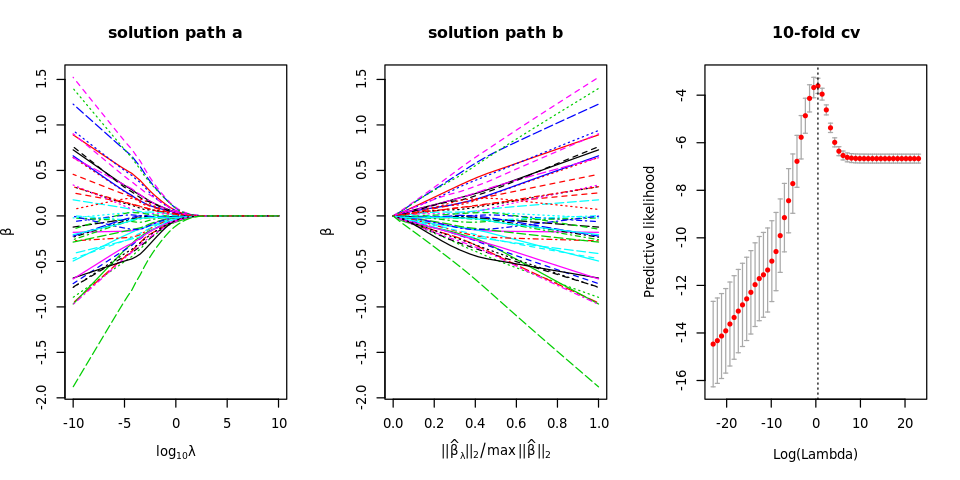

In [5]:
library(repr)
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,3))
matplot(loglam,t(fit_logit$w[-1,]),type="l",xlab=expression(log[10]*lambda),
        ylab=expression(beta),main="solution path a")
matplot(sqrt(colSums(fit_logit$w[-1,]^2)/sum(fit_logit$w[-1,nlam]^2)),t(fit_logit$w[-1,]),type="l",xlab=expression("||"*hat(beta)[lambda]*"||"[2]/max("||"*hat(beta)*"||"[2])),
        ylab=expression(beta),main="solution path b")
plot(fit_cv,main="10-fold cv")